<a href="https://colab.research.google.com/github/GlassesNoGlasses/TFProjects/blob/spam_detection/Flower_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import github repo

!git clone https://github.com/GlassesNoGlasses/TFProjects.git

Cloning into 'TFProjects'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 38 (delta 10), reused 14 (delta 2), pack-reused 0
Receiving objects: 100% (38/38), 455.91 KiB | 8.29 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [2]:
# Required imports

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
# Get flower data from tensorflow web data
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

228813984/228813984 [==============================] - 4s 0us/step


In [4]:
# Check images downloaded successfully

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


**Idea:** Now that we have the images, we need to load them into a tf dataset to use them properly.

In [5]:
# Loading parameters

batch_size = 32
img_height = 180
img_width = 180

In [6]:
# Split images into training and testing/validation

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [7]:
# View class names of split datasets

class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


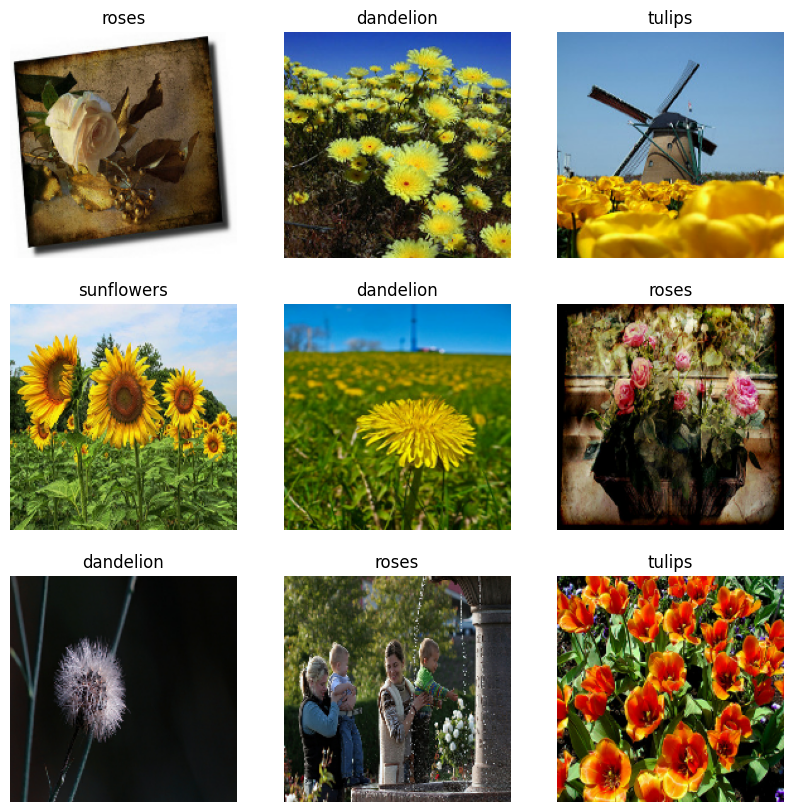

In [8]:
# Visualization of data being used

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
# Cache the dataset and prefetch images

# Dataset.cache(): Caches dataset to save time and reduce bottleneck fetching
# Dataset.prefetch(): Prefetches next image during training/processing

# How many images to fetch for each batch
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
# Standardize RGB data

# AKA: Convert RGB [0, 255] to [0, 1] for easier processing
normalization_layer = layers.Rescaling(1./255)

In [11]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [12]:
# Creating the model

num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [13]:
# Compiling the model with loss & optimzier functions

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [15]:
# Train model

epochs=15

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 10s 54ms/step - loss: 1.3395 - accuracy: 0.4217 - val_loss: 1.0657 - val_accuracy: 0.5777
Epoch 2/15
92/92 [==============================] - 2s 21ms/step - loss: 0.9722 - accuracy: 0.6175 - val_loss: 1.0273 - val_accuracy: 0.5736
Epoch 3/15
92/92 [==============================] - 2s 21ms/step - loss: 0.8015 - accuracy: 0.7013 - val_loss: 0.8769 - val_accuracy: 0.6594
Epoch 4/15
92/92 [==============================] - 2s 21ms/step - loss: 0.5989 - accuracy: 0.7888 - val_loss: 0.9260 - val_accuracy: 0.6512
Epoch 5/15
92/92 [==============================] - 2s 24ms/step - loss: 0.3781 - accuracy: 0.8655 - val_loss: 1.0615 - val_accuracy: 0.6362
Epoch 6/15
92/92 [==============================] - 2s 21ms/step - loss: 0.2162 - accuracy: 0.9326 - val_loss: 1.1888 - val_accuracy: 0.6499
Epoch 7/15
92/92 [==============================] - 2s 21ms/step - loss: 0.1008 - accuracy: 0.9690 - val_loss: 1.5162 - val_accuracy: 0.6362
Epoch 8/15
9

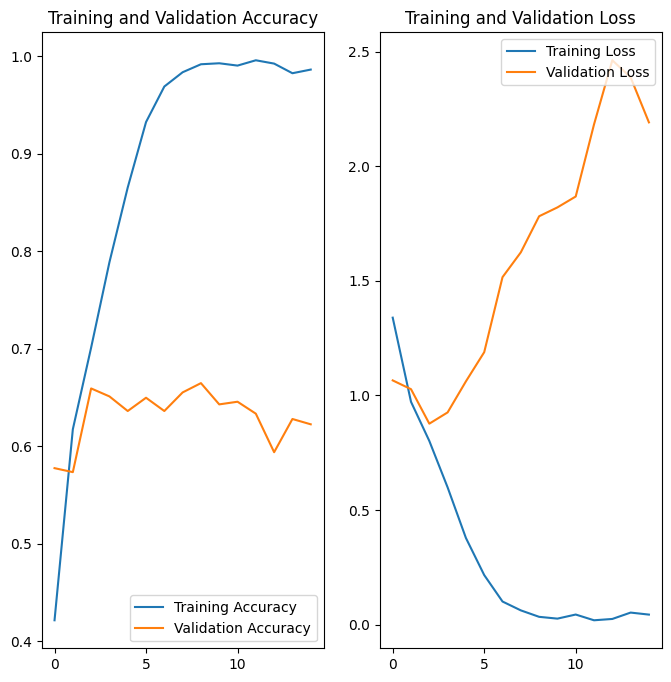

In [16]:
# Visualize Results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Overfitting**: In the graphs above, the training data has a high degree of accuracy compared to validation data; vice-versa for the loss. This implies overfitting of training data, as the model is not able to accurately predict validation data but does well with training data.

**Data Augmentation**: The act of using training data to generate additional training data with mutations. This helps resolve overfitting as it increases the number of distinct training examples for the model to analyze.

In [17]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

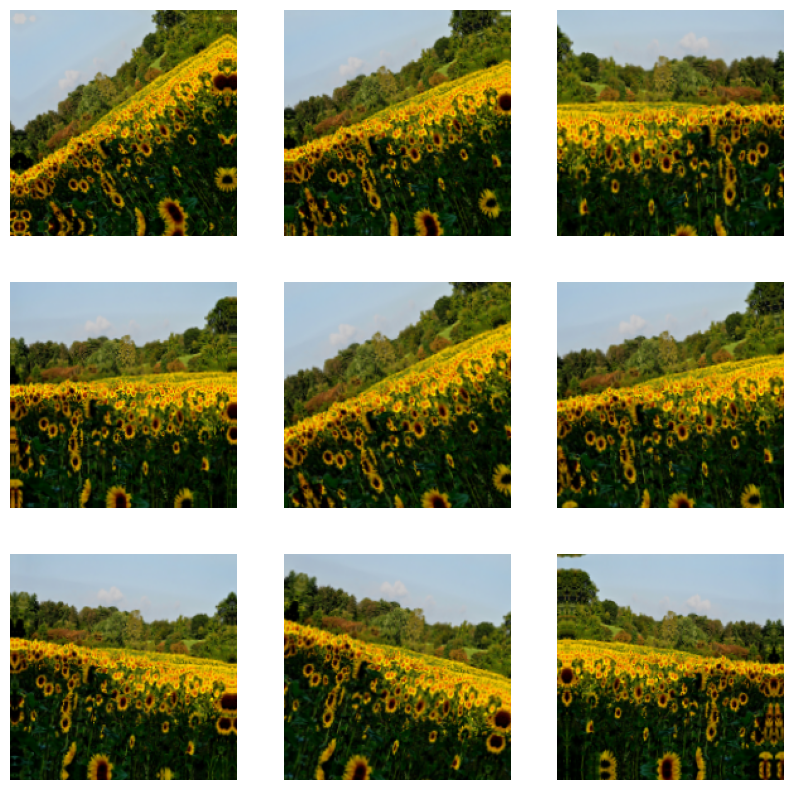

In [18]:
# Data Augmentation Visualization

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

**Dropout Regularization**: A regularization method for neural networks; randomly select a fixed number of nodes to "drop" and remove from the training process.

Helps prevent overfitting by reducing neurons' tendencies to "co-adapt" and "think the same" during training.

In [20]:
# Dropout 20% of nodes from applied layer

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [21]:
# Compile model again

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [23]:
# Train again

epochs = 15

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 6s 32ms/step - loss: 1.3408 - accuracy: 0.4363 - val_loss: 1.1160 - val_accuracy: 0.5695
Epoch 2/15
92/92 [==============================] - 3s 30ms/step - loss: 1.0543 - accuracy: 0.5770 - val_loss: 1.0176 - val_accuracy: 0.5831
Epoch 3/15
92/92 [==============================] - 3s 32ms/step - loss: 0.9788 - accuracy: 0.6168 - val_loss: 1.1205 - val_accuracy: 0.5395
Epoch 4/15
92/92 [==============================] - 3s 30ms/step - loss: 0.9282 - accuracy: 0.6495 - val_loss: 0.9121 - val_accuracy: 0.6540
Epoch 5/15
92/92 [==============================] - 3s 30ms/step - loss: 0.8911 - accuracy: 0.6567 - val_loss: 0.8469 - val_accuracy: 0.6744
Epoch 6/15
92/92 [==============================] - 3s 31ms/step - loss: 0.8266 - accuracy: 0.6792 - val_loss: 0.8586 - val_accuracy: 0.6662
Epoch 7/15
92/92 [==============================] - 3s 32ms/step - loss: 0.7715 - accuracy: 0.7071 - val_loss: 0.8047 - val_accuracy: 0.6894
Epoch 8/15
92